In [73]:
import pandas as pd
import numpy as np
import import_ipynb
import utils_cdt as cdt
from datetime import datetime
from pyspark.sql import SparkSession, Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.storagelevel import StorageLevel 
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.tree import DecisionTreeRegressor 
import matplotlib.pyplot as plt
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

In [61]:
infoDataBases = {"ip":"AZ2D-MASKDB-220.DEVCDT.COM.BR","base":"Controly"}

In [62]:
#Consulta de BASE SQL Server
consulta = cdt.resultQuery("mdl_contas_saldos.sql")
consulta_iof = cdt.resultQuery("mdl_base_iof.sql")
df = cdt.extrairDados(infoDataBases,consulta,path='../data/',arquivo="mdl_contas_saldo_"+infoDataBases["base"],spark=False,objSpark=None)
df_iof = cdt.extrairDados(infoDataBases,consulta_iof,path='../data/',arquivo="mdl_base_iof_"+infoDataBases["base"],spark=False,objSpark=None)

In [63]:
df['dtvencimento'] = pd.to_datetime(df.DataVencimentoPadrao, format="%d/%m/%Y")
df_iof['dtvencimento'] = pd.to_datetime(df_iof.datavencimentopadrao, format="%Y-%m-%d")

In [64]:
df.head(2)

,Id_Conta,DataVencimentoPadrao,TarifasNacionais,ParcelasNaoFinanciaveis,SaldoAtualFinal,BaseCalculo,seguros,EncargosFinanciamento,DebitosRecorrentes,TotalComprasSaques,SaldoExtratoAnterior,ValorMinimoExtrato,dtvencimento
0,1338692,05/01/2020,0.0,0.0,363.93,0.0,0.0,0.0,0.0,269.14,136.20,56.67,2020-01-05
1,1338842,05/01/2020,0.0,0.0,248.82,0.0,0.0,0.0,0.0,0.00,226.64,37.32,2020-01-05


In [65]:
df_iof.head(2)

,datavencimentopadrao,Id_Conta,valoriof,dtvencimento
0,2020-02-21,1001779,10.48,2020-02-21
1,2020-02-15,1003210,1.98,2020-02-15


In [66]:
df = df.merge(df_iof, on=['Id_Conta','dtvencimento'], how='left')
df = df.fillna(0)

In [67]:
df.head(2)

,Id_Conta,DataVencimentoPadrao,TarifasNacionais,ParcelasNaoFinanciaveis,SaldoAtualFinal,BaseCalculo,seguros,EncargosFinanciamento,DebitosRecorrentes,TotalComprasSaques,SaldoExtratoAnterior,ValorMinimoExtrato,dtvencimento,datavencimentopadrao,valoriof
0,1338692,05/01/2020,0.0,0.0,363.93,0.0,0.0,0.0,0.0,269.14,136.20,56.67,2020-01-05,0,0.0
1,1338842,05/01/2020,0.0,0.0,248.82,0.0,0.0,0.0,0.0,0.00,226.64,37.32,2020-01-05,0,0.0


### [transformDataSet] - Transforma dois arrays em colunas Previsto X Real

In [68]:
def transformDataSet(previsto, real):
    d = {"Previsto": [x[0] for x in previsto], "Real":[x[0] for x in real]}
    df_resultado = pd.DataFrame(data=d)
    df_resultado['diff'] = df_resultado.Previsto - df_resultado.Real
    df_resultado['porcen'] =  np.absolute(((df_resultado.Previsto / df_resultado.Real)*100)-100)
    df_resultado = df_resultado.round(2)
    return df_resultado

### [getresultdataset] - Printa os totais previsto x reais x diferença x porcentagem

In [69]:
def getresultdataset(dt, model_name):
    total_diff = dt.aggregate(['sum'])['diff'][0]
    total_real = dt.aggregate(['sum'])['Real'][0]
    total_prev = dt.aggregate(['sum'])['Previsto'][0]
    print("["+model_name+"] - Total Real:  %.2f" %(total_real))
    print("["+model_name+"] - Total Prev:  %.2f" %(total_prev))
    print("["+model_name+"] - Total Diff:  %.2f" %(total_diff))
    print("["+model_name+"] - Total Porcentagem de diferença do previsto x real:  {:.2f}%".format(np.absolute(((total_diff / total_real)*100))))

In [70]:
# Remove colunas que contem ID
cols_id = [c for c in df.columns if c.lower()[:2] == 'id']
df = df.drop(columns=cols_id)


# Mantem apenas colunas numericas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)


# Definindo variaveis preditoras e prevista
preditoras = []
preditoras =  df.columns.to_list()
preditoras.remove("ValorMinimoExtrato")
prevista = ['ValorMinimoExtrato']

In [71]:
X_treino, Y_treino, X_teste, Y_teste = cdt.preperTreinoTeste(df, preditoras, prevista, 0.3)

In [78]:
dtr_model = DecisionTreeRegressor(random_state=42).fit(X_treino, Y_treino)

Text(0.5, 1.0, 'Importância de cada feature')

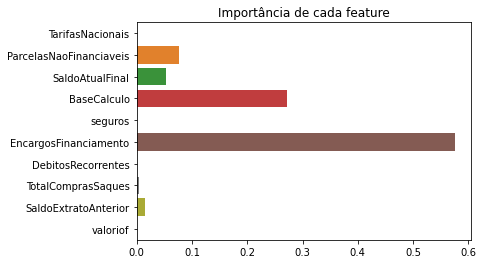

In [79]:
import seaborn as sns
importances = pd.Series(data=dtr_model.feature_importances_, index=preditoras)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [52]:
#from sklearn.feature_selection import RFE
#rfe = RFE(randomForestRegression, step=1).fit(X_treino, Y_treino)

In [80]:
dtr_model.score(X_teste,Y_teste)

0.9876503980623164

In [81]:
Y_Predict = dtr_model.predict(X_teste)
Y_Predict = Y_Predict.reshape(Y_Predict.shape[0],1)
df_final = transformDataSet(Y_Predict, Y_teste)
getresultdataset(df_final, "DecisionTreeRegressor")

[DecisionTreeRegressor] - Total Real:  17648575.00
[DecisionTreeRegressor] - Total Prev:  17642309.00
[DecisionTreeRegressor] - Total Diff:  -6266.00
[DecisionTreeRegressor] - Total Porcentagem de diferença do previsto x real:  0.04%


In [54]:
#rfe.score(X_teste,Y_teste)

In [82]:
filename = 'models/dtr_saldo_minimoExtrato.sav'
pickle.dump(dtr_model, open(filename, 'wb'))

## Prevendo novos valores com base no Modelo treinado anteriormente

In [154]:
#Carregando modelo 
model_forest = pickle.load(open('models/dtr_saldo_minimoExtrato.sav', 'rb'))

In [139]:
#Consulta de BASE SQL Server
infoDataBases = {"ip":"AZ2D-MASKDB-220.DEVCDT.COM.BR","base":"Controly"}
consulta = cdt.resultQuery("contas_saldos.sql")
consultaiof = cdt.resultQuery("base_iof.sql")
df = cdt.extrairDados(infoDataBases,consulta,path='../data/',arquivo="contas_saldo_"+infoDataBases["base"],spark=False,objSpark=None)
df_iof = cdt.extrairDados(infoDataBases,consultaiof,path='../data/',arquivo="base_iof_"+infoDataBases["base"],spark=False,objSpark=None)

In [140]:
df.head(2)

,Id_Conta,DataVencimentoPadrao,TarifasNacionais,ParcelasNaoFinanciaveis,SaldoAtualFinal,BaseCalculo,seguros,EncargosFinanciamento,DebitosRecorrentes,TotalComprasSaques,SaldoExtratoAnterior,ValorMinimoExtrato
0,181346,01/05/2020,0.0,0.0,554.88,-1072.56,0.0,0.0,0.0,1031.54,405.60,83.23
1,181106,01/05/2020,0.0,0.0,209.25,0.00,0.0,0.0,0.0,209.25,177.62,31.39


In [138]:
df_iof.head(2)

,DataVencimentoPadrao,Id_Conta,valoriof
0,2020-05-01,2531281,0.67
1,2020-05-01,1477784,0.70


In [141]:
df['dtvencimento'] = pd.to_datetime(df.DataVencimentoPadrao, format="%d/%m/%Y")
df_iof['dtvencimento'] = pd.to_datetime(df_iof.DataVencimentoPadrao, format="%Y-%m-%d")

In [142]:
df = df.merge(df_iof, on=['Id_Conta','dtvencimento'], how='left')
df = df.fillna(0)

In [143]:
df.head(2)

,Id_Conta,DataVencimentoPadrao_x,TarifasNacionais,ParcelasNaoFinanciaveis,SaldoAtualFinal,BaseCalculo,seguros,EncargosFinanciamento,DebitosRecorrentes,TotalComprasSaques,SaldoExtratoAnterior,ValorMinimoExtrato,dtvencimento,DataVencimentoPadrao_y,valoriof
0,181346,01/05/2020,0.0,0.0,554.88,-1072.56,0.0,0.0,0.0,1031.54,405.60,83.23,2020-05-01,0,0.0
1,181106,01/05/2020,0.0,0.0,209.25,0.00,0.0,0.0,0.0,209.25,177.62,31.39,2020-05-01,0,0.0


In [160]:
# Remove colunas que contem ID
cols_id = [c for c in df.columns if c.lower()[:2] == 'id']
df = df.drop(columns=cols_id)


# Mantem apenas colunas numericas
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)

# Definindo variaveis preditoras e prevista
preditoras = []
preditoras =  df.columns.to_list()
preditoras.remove("ValorMinimoExtrato")
prevista = ['ValorMinimoExtrato']

In [147]:
df.head(2)

,TarifasNacionais,ParcelasNaoFinanciaveis,SaldoAtualFinal,BaseCalculo,seguros,EncargosFinanciamento,DebitosRecorrentes,TotalComprasSaques,SaldoExtratoAnterior,ValorMinimoExtrato,valoriof
0,0.0,0.0,554.88,-1072.56,0.0,0.0,0.0,1031.54,405.60,83.23,0.0
1,0.0,0.0,209.25,0.00,0.0,0.0,0.0,209.25,177.62,31.39,0.0


In [161]:
# Seleção de variáveis preditoras (Feature Selection)
atributos = preditoras
# Variável a ser prevista
atrib_prev = prevista

# Criando objetos
X = np.absolute(df[atributos].values)
Y = df[atrib_prev].values

In [162]:
X.shape

(15323, 10)

In [163]:
Y.shape

(15323, 1)

In [164]:
dtr_model.score(X,Y)

0.9888902516768996

In [169]:
Y_Predict = dtr_model.predict(X)
Y_Predict = Y_Predict.reshape(Y_Predict.shape[0],1)
df_final = transformDataSet(Y_Predict, Y)
getresultdataset(df_final, "DecisionTreeRegressor")

[DecisionTreeRegressor] - Total Real:  3127531.57
[DecisionTreeRegressor] - Total Prev:  3118984.00
[DecisionTreeRegressor] - Total Diff:  -8547.57
[DecisionTreeRegressor] - Total Porcentagem de diferença do previsto x real:  0.27%
